In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
!head -n 50 ../logs/block_10_train.log

2020-11-29 16:38:50: INFO: {'batch_size': 1,
 'input_shape': '1 84 250 250',
 'lr': 0.001,
 'max_len': 250,
 'n_blocks': 10,
 'n_dist_bins': 10,
 'n_epochs': 30,
 'name': 'block_10_train',
 'pssm_dir': 'pssm',
 'tert_dir': 'tert',
 'train_df': './input/train_dataset.csv',
 'valid_df': './input/validation_dataset.csv'}
2020-11-29 16:38:50: INFO: device: cuda
2020-11-29 17:10:21: INFO: Epoch: 01 | Time: 31.39m
2020-11-29 17:10:21: INFO: 	Train Loss: 1.549 | Train Acc: 50.18%
2020-11-29 17:10:21: INFO: 	Valid Loss: 1.396 | Valid Acc: 54.59%
2020-11-29 17:41:38: INFO: Epoch: 02 | Time: 62.68m
2020-11-29 17:41:38: INFO: 	Train Loss: 1.392 | Train Acc: 53.79%
2020-11-29 17:41:38: INFO: 	Valid Loss: 1.353 | Valid Acc: 54.79%
2020-11-29 18:12:57: INFO: Epoch: 03 | Time: 93.99m
2020-11-29 18:12:57: INFO: 	Train Loss: 1.329 | Train Acc: 55.25%
2020-11-29 18:12:57: INFO: 	Valid Loss: 1.414 | Valid Acc: 53.04%
2020-11-29 18:44:17: INFO: Epoch: 04 | Time: 125.33m
2020-11-29 18:44:17: INFO: 	Train L

In [47]:
def parse_log(log_path):
    
    '''save losses, accuracy, timing at each epoch'''
    
    lines = Path(log_path).read_text().splitlines()
    
    res = []
    for i, line in enumerate(lines):
        if 'Epoch' in line:
            time = line.split()[-1][:-1]  # drop min
            epoch = line.split()[-4]
            
            train_loss = lines[i+1].split()[-5]
            train_acc = lines[i+1].split()[-1][:-1]
            
            valid_loss = lines[i+2].split()[-5]
            valid_acc = lines[i+2].split()[-1][:-1]
            
            res.append([epoch, time, train_loss, train_acc, valid_loss, valid_acc])
            
    df = pd.DataFrame(res, columns=['epoch', 'time', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'])
    df = df.apply(pd.to_numeric, errors='ignore') 
    # subtract previous time value to get per epoch times
    first_epoch = df.loc[0, 'time']
    df['time'] = df['time'].diff().fillna(first_epoch)
    
    return df

In [49]:
log_df = parse_log('../logs/block_10_train.log')

In [50]:
log_df.head()

,epoch,time,train_loss,train_acc,valid_loss,valid_acc
0,1,31.39,1.549,50.18,1.396,54.59
1,2,31.29,1.392,53.79,1.353,54.79
2,3,31.31,1.329,55.25,1.414,53.04
3,4,31.34,1.283,56.38,1.381,54.54
4,5,31.28,1.245,57.37,1.413,53.70


In [84]:
def plot_logs(log_df):
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    # losses
    ax[0].plot(log_df['epoch'], log_df['train_loss'], label='Training')
    ax[0].plot(log_df['epoch'], log_df['valid_loss'], label='Valid')
    
    # acc
    ax[1].plot(log_df['epoch'], log_df['train_acc'], label='Training')
    ax[1].plot(log_df['epoch'], log_df['valid_acc'], label='Valid')
    
    for a in ax:
        a.grid(alpha=0.2)
        a.set_xlabel('Epoch')
        
        
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Accuracy')
    
    #ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].legend()
    
    ax[0].set_title('Model Loss')
    ax[1].set_title('Model Accuracy')
    
    plt.tight_layout()
    

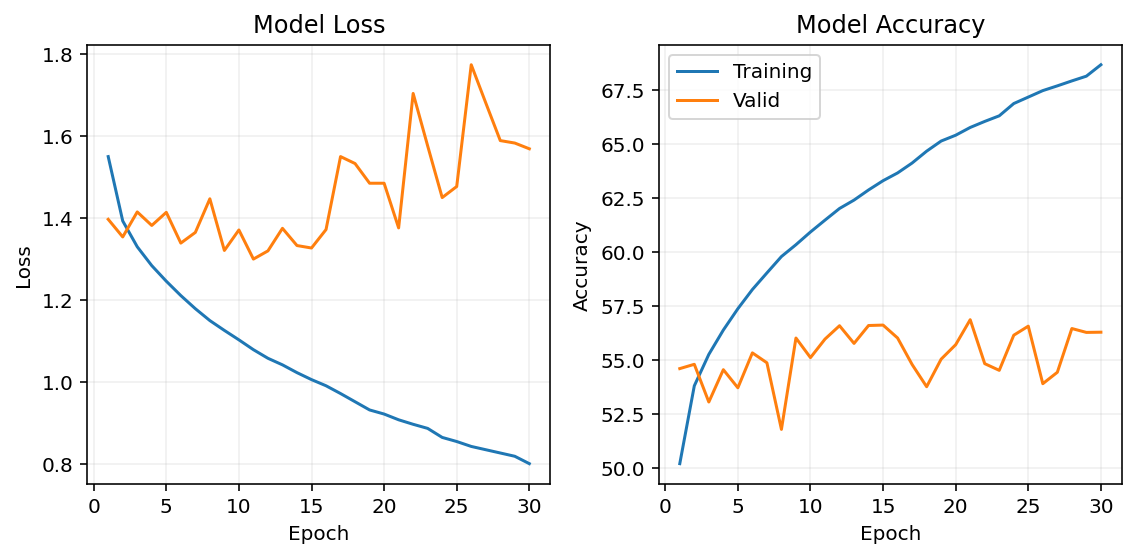

In [85]:
plot_logs(log_df)

In [176]:
pd.read_csv('../df_agg.csv').head()

,metric,0
0,long_l,0.803523
1,long_l/2,0.783668
2,long_l/5,0.748080
3,med_l,0.813544
4,med_l/2,0.779403


In [187]:
# plot contact precisions

def plot_contact_p(contact_df_path):
    
    # reorder short -> med -> long
    # l -> l/2 -> l/5
    df = pd.read_csv(contact_df_path, header=0, names=['metric', 'score'])
    df['contact_type'] = df['metric'].str.split('_', expand=True)[1]
    df['distance'] = df['metric'].str.split('_', expand=True)[0]
    
    df['contact_type'] = df['contact_type'].astype('category')
    df['distance'] = df['distance'].astype('category')
    
    df['contact_type'].cat.reorder_categories(['l', 'l/2', 'l/5'], inplace=True, ordered=True)
    df['distance'].cat.reorder_categories(['short', 'med', 'long'], inplace=True, ordered=True)
    
    df = df.sort_values(by=['contact_type', 'distance'])
    
    fig = plt.figure(figsize=(8, 4.5))
    
    bar_width = 0.2
    
    x1 = np.arange(len(df) / 3)
    x2 = [x + bar_width for x in x1]
    x3 = [x + bar_width for x in x2]
    
    cols = ['#0C5DA5', '#00B945', '#FF9500']
    
    for cat, x_ind, col in zip(['l', 'l/2', 'l/5'], [x1, x2, x3], cols):
        subset = df.query("contact_type == @cat")
        
        plt.bar(x_ind, subset['score'], width=bar_width, color=col, edgecolor='k', alpha=0.8, label=f'{cat.title()}')
        
    plt.xticks(x2, ['Short', 'Medium', 'Long'])
        
    plt.grid(alpha=0.2)
    plt.gca().set_axisbelow(True)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Contact Precision')
    plt.ylabel('Accuracy')
    

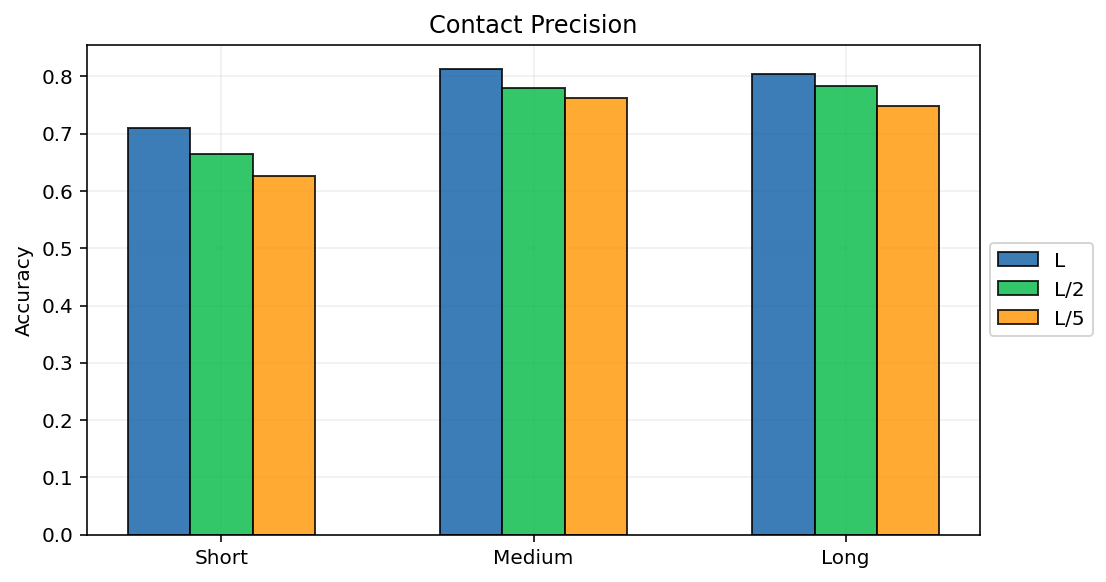

In [188]:
plot_contact_p('../df_agg.csv')